# Synchro Project
- [github link](https://github.com/romainmartinez/envergo)

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# Figures
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
%matplotlib inline

# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Get data

In [2]:
DATA_PATH = Path('./data/zTable.xlsx')
df = pd.read_excel(DATA_PATH)

In [3]:
# athletes' name
names = df['name']
# variables
X = df[[
    'ADD/G', 'ADD/D', 'ABD/G', 'ABD/D', 'ER/G', 'ER/D', 'IR/G', 'IR/D',
    'EXT/G', 'EXT/D', 'FLEX/G', 'FLEX/D'
]]
# targets
y = df[['EGG MEAN', 'EGG MAX', 'BODYBOOST', 'DYN MEAN', 'DYN MAX']]
# not included: 'DYN SD', 'EGG MIN ', 'EGG SD', 'EGG MAX-MIN'
X.head()

,ADD/G,ADD/D,ABD/G,ABD/D,ER/G,ER/D,IR/G,IR/D,EXT/G,EXT/D,FLEX/G,FLEX/D
0,287.05,285.00,206.85,179.90,92.85,94.95,52.3,51.95,166.65,196.70,183.00,146.00
1,292.75,302.75,239.85,207.85,109.25,103.25,98.4,84.05,308.00,257.45,156.60,123.35
2,252.40,258.55,233.45,233.65,69.30,68.80,120.0,119.80,141.10,113.20,199.55,204.80
3,213.45,227.40,174.00,132.10,54.20,56.40,39.9,37.20,138.55,2.00,117.75,112.25
4,281.75,296.20,258.65,227.25,97.25,99.05,77.2,62.45,207.15,166.95,158.50,152.85


### nan remover

In [4]:
nan_id = np.argwhere(np.isnan(X.values))
for i in nan_id:
    print(f'participant no.: {i[0]}')
    print(f'\ttest: {X.columns[i[1]]}')
    # if left take right, left otherwise
    if X.columns[i[1]][-1] == 'G':
        replacer = i[1] + 1
    else:
        replacer = i[1] - 1
    print(f'\t\t"{X.iloc[i[0], i[1]]}" replace by "{X.iloc[i[0], replacer]}"')
    X.at[i[0], X.columns[i[1]]] = X.at[i[0], X.columns[replacer]]

participant no.: 5
	test: ADD/D
		"nan" replace by "323.25"
participant no.: 41
	test: IR/G
		"nan" replace by "118.95"
participant no.: 90
	test: IR/G
		"nan" replace by "92.25"


### X description
- `ADD`: adduction test
- `ABD`: abduction test
- `ER`: external rotation test
- `IR`: internal rotation test
- `EXT`: extension test
- `FLEX`: flexion test




In [5]:
X.head()

,ADD/G,ADD/D,ABD/G,ABD/D,ER/G,ER/D,IR/G,IR/D,EXT/G,EXT/D,FLEX/G,FLEX/D
0,287.05,285.00,206.85,179.90,92.85,94.95,52.3,51.95,166.65,196.70,183.00,146.00
1,292.75,302.75,239.85,207.85,109.25,103.25,98.4,84.05,308.00,257.45,156.60,123.35
2,252.40,258.55,233.45,233.65,69.30,68.80,120.0,119.80,141.10,113.20,199.55,204.80
3,213.45,227.40,174.00,132.10,54.20,56.40,39.9,37.20,138.55,2.00,117.75,112.25
4,281.75,296.20,258.65,227.25,97.25,99.05,77.2,62.45,207.15,166.95,158.50,152.85


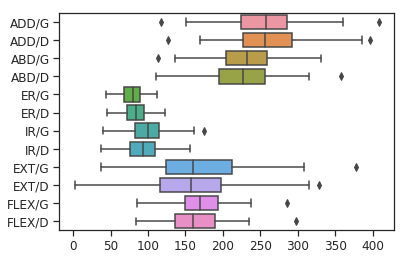

In [6]:
sns.boxplot(data=X, orient='h');

### y description
- `EGG MEAN`: mean eggbeater score
- `EGG MAX`: max. eggbeater score
- `BODYBOOST`: bodyboost score
- `DYN MEAN`: mean dynamometer force
- `DYN MAX`: max. dynamometer force

In [7]:
y.head()

,EGG MEAN,EGG MAX,BODYBOOST,DYN MEAN,DYN MAX
0,8.083333,8.5,9.5,6.770000,8.33
1,7.083333,7.5,8.5,7.762753,9.43
2,7.833333,8.0,8.5,6.725683,8.76
3,7.416667,8.0,8.5,7.315823,9.86
4,7.333333,7.5,9.0,8.995158,10.77


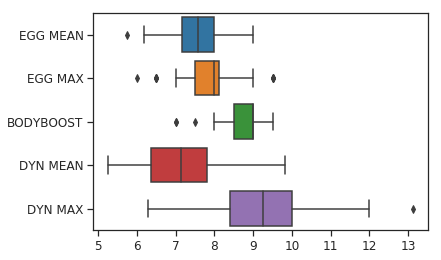

In [8]:
sns.boxplot(data=y, orient='h');

## Add features

### Fscore
Let's try to transform each *left* and *right* tests into a single "Fscore" such as:
$$F_{\text{score}} = 2 \times \frac{\text{left} \times \text{right}}{\text{left} + \text{right}}$$

This formula favors left & right tests that are similar and therefore penalizes asymmetries.

In [9]:
def f_score(a, b):
    """Takes two columns and compute the F score."""
    return 2 * (a * b) / (a + b)

### Imbalance
Let's try to compute the imbalance score for each test, such as:
$$\text{imbalance} = |\frac{\text{left} - \text{right}}{\text{left}}| * 100$$

In [10]:
def imbalance(a, b):
    """compute the imbalance score, in percentage."""
    return np.abs((a - b) / a) * 100

In [11]:
X_f_score = pd.DataFrame()
for name, icol in X.iteritems():
    b = np.empty(0)
    if name[-1] == 'G':
        a = icol
    else:
        b = icol
    if b.any():
        X_f_score[name[:-2]] = f_score(a, b)
        X_f_score[f'imb_{name[:-2]}'] = imbalance(a, b)

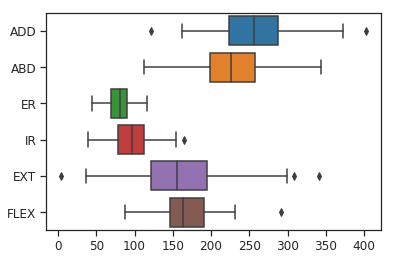

In [12]:
sns.boxplot(data=X_f_score[[i for i in X_f_score if i[0] != 'i']], orient='h');

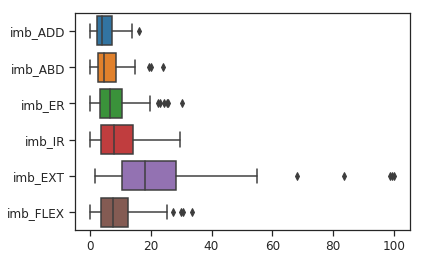

In [13]:
sns.boxplot(data=X_f_score[[i for i in X_f_score if i[0] == 'i']], orient='h');

## Fitting an ensemble model

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_f_score, y, test_size=0.2, random_state=RANDOM_SEED)

In [31]:
import xgboost

label = 'BODYBOOST'

dtrain = xgboost.DMatrix(X_train, label=y_train[label])
dtest = xgboost.DMatrix(X_test, label=y_test[label])

params = {
    "eta": 0.01,
    "objective": "reg:linear",
    "subsample": 0.5,
    "base_score": np.mean(y_train[label]),
    "eval_metric": "logloss"
}

boosted = xgboost.train(
#     params,
    dtrain,
    num_boost_round=5000,
    evals=[(dtest, "Test")],
    verbose_eval=25,
    early_stopping_rounds=100
)

TypeError: train() missing 1 required positional argument: 'dtrain'

In [29]:
from sklearn.metrics import mean_squared_error

threshold = 0.7
dpredict = (boosted.predict(dtest, ntree_limit=boosted.best_iteration) > threshold).astype(int)

In [28]:
from sklearn.metrics import mean_squared_error
import spm1d

def mape(y_test, y_pred):
    val = (np.abs((y_test - y_pred) / y_test)) * 100
    return np.mean(val), np.std(val)

def mse(y_test, y_pred):
    val = ((y_test - y_pred) ** 2)
    return np.mean(val), np.std(val)

def rmse(y_test, y_pred):
    val = np.sqrt(((y_test - y_pred) ** 2))
    return np.mean(val), np.std(val)

In [30]:
dpredict

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])